# Chapter 3 - Deep Q-learning
### Deep Reinforcement Learning *in Action*

##### Listing 3.1

In [1]:
from Gridworld import Gridworld
game = Gridworld(size=4, mode='static')

In [2]:
game.display()

In [3]:
game.makeMove('d')
game.makeMove('d')
game.makeMove('l')
game.display()

array([['+', '-', ' ', ' '],
       [' ', 'W', ' ', ' '],
       [' ', ' ', 'P', ' '],
       [' ', ' ', ' ', ' ']], dtype='<U2')

In [4]:
game.reward()

-1

In [5]:
game.board.render_np()

array([[[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 0]],

       [[1, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 1, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]]], dtype=uint8)

##### Listing 3.2

In [6]:
import numpy as np
import torch
from Gridworld import Gridworld
from IPython.display import clear_output
import random
from matplotlib import pylab as plt

l1 = 64
l2 = 150
l3 = 100
l4 = 4

model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.ReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.ReLU(),
    torch.nn.Linear(l3,l4)
)
loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

gamma = 0.9
epsilon = 1.0
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

gamma = 0.9
epsilon = 1.0

##### Listing 3.3

In [7]:
action_set = {
    0: 'u',
    1: 'd',
    2: 'l',
    3: 'r',
}

In [9]:
epochs = 1000
losses = [] #A
for i in range(epochs): #B
    game = Gridworld(size=4, mode='static') #C
    state_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0 #D
    state = torch.from_numpy(state_).float() #E
    status = 1 #F
    while(status == 1): #G
        qval = model(state) #H
        qval_ = qval.data.numpy()
        if (random.random() < epsilon): #I
            action_ = np.random.randint(0,4)
        else:
            action_ = np.argmax(qval_)
        
        action = action_set[action_] #J
        game.makeMove(action) #K
        state2_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
        state2 = torch.from_numpy(state2_).float() #L
        reward = game.reward()
        with torch.no_grad():
            newQ = model(state2.reshape(1,64))
        maxQ = torch.max(newQ) #M
        if reward == -1: #N
            Y = reward + (gamma * maxQ)
        else:
            Y = reward
        Y = torch.Tensor([Y]).detach()
        X = qval.squeeze()[action_] #O
        loss = loss_fn(X, Y) #P
        print(i, loss.item())
        clear_output(wait=True)
        optimizer.zero_grad()
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
        state1 = state2
        if reward != -1: #Q
            status = 0
    if epsilon > 0.1: #R
        epsilon -= (1/epochs)

999 336.1863098144531


Text(0, 0.5, 'Loss')

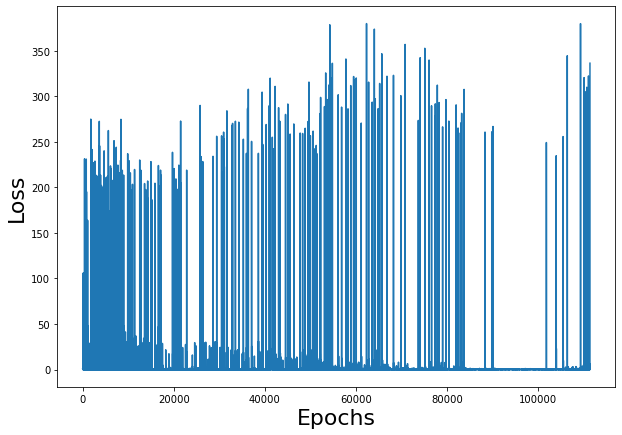

In [10]:
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Epochs",fontsize=22)
plt.ylabel("Loss",fontsize=22)

##### PyTorch Automatic Differentiation Review

In [11]:
m = torch.Tensor([2.0])
m.requires_grad=True
b = torch.Tensor([1.0])
b.requires_grad=True
def linear_model(x,m,b):
    y = m + b#@ x + b
    return y

In [12]:
#with torch.no_grad():
y = linear_model(torch.Tensor([4]),m,b)

In [13]:
y.grad_fn

In [14]:
y.backward()

In [15]:
m.grad

tensor([1.])

##### Listing 3.4

In [16]:
def test_model(model, mode='static', display=True):
    i = 0
    test_game = Gridworld(mode=mode)
    state_ = test_game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
    state = torch.from_numpy(state_).float()
    if display:
        print("Initial State:")
        print(test_game.display())
    status = 1
    while(status == 1): #A
        qval = model(state)
        qval_ = qval.data.numpy()
        action_ = np.argmax(qval_) #B
        action = action_set[action_]
        if display:
            print('Move #: %s; Taking action: %s' % (i, action))
        test_game.makeMove(action)
        state_ = test_game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
        state = torch.from_numpy(state_).float()
        if display:
            print(test_game.display())
        reward = test_game.reward()
        if reward != -1:
            if reward > 0:
                status = 2
                if display:
                    print("Game won! Reward: %s" % (reward,))
            else:
                status = 0
                if display:
                    print("Game LOST. Reward: %s" % (reward,))
        i += 1
        if (i > 15):
            if display:
                print("Game lost; too many moves.")
            break
    
    win = True if status == 2 else False
    return win

In [17]:
test_model(model)

Initial State:
[['+' '-' ' ' 'P']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 0; Taking action: l
[['+' '-' 'P' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 1; Taking action: l
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Game LOST. Reward: -10


False

##### Listing 3.5

In [18]:
l1 = 64
l2 = 150
l3 = 100
l4 = 4

model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.ReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.ReLU(),
    torch.nn.Linear(l3,l4)
)
loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

gamma = 0.9
epsilon = 0.3

In [19]:
from collections import deque
epochs = 5000
losses = []
mem_size = 1000 #A
batch_size = 200 #B
replay = deque(maxlen=mem_size) #C
max_moves = 50 #D
h = 0
for i in range(epochs):
    game = Gridworld(size=4, mode='random')
    state1_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
    state1 = torch.from_numpy(state1_).float()
    status = 1
    mov = 0
    while(status == 1): 
        mov += 1
        qval = model(state1) #E
        qval_ = qval.data.numpy()
        if (random.random() < epsilon): #F
            action_ = np.random.randint(0,4)
        else:
            action_ = np.argmax(qval_)
        
        action = action_set[action_]
        game.makeMove(action)
        state2_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
        state2 = torch.from_numpy(state2_).float()
        reward = game.reward()
        done = True if reward > 0 else False
        exp =  (state1, action_, reward, state2, done) #G
        replay.append(exp) #H
        state1 = state2
        
        if len(replay) > batch_size: #I
            minibatch = random.sample(replay, batch_size) #J
            state1_batch = torch.cat([s1 for (s1,a,r,s2,d) in minibatch]) #K
            action_batch = torch.Tensor([a for (s1,a,r,s2,d) in minibatch])
            reward_batch = torch.Tensor([r for (s1,a,r,s2,d) in minibatch])
            state2_batch = torch.cat([s2 for (s1,a,r,s2,d) in minibatch])
            done_batch = torch.Tensor([d for (s1,a,r,s2,d) in minibatch])
            
            Q1 = model(state1_batch) #L
            with torch.no_grad():
                Q2 = model(state2_batch) #M
            
            Y = reward_batch + gamma * ((1 - done_batch) * torch.max(Q2,dim=1)[0]) #N
            X = Q1.gather(dim=1,index=action_batch.long().unsqueeze(dim=1)).squeeze()
            loss = loss_fn(X, Y.detach())
            print(i, loss.item())
            clear_output(wait=True)
            optimizer.zero_grad()
            loss.backward()
            losses.append(loss.item())
            optimizer.step()

        if reward != -1 or mov > max_moves: #O
            status = 0
            mov = 0
losses = np.array(losses)

#A Set the total size of the experience replay memory
#B Set the minibatch size
#C Create the memory replay as a deque list
#D Maximum number of moves before game is over
#E Compute Q-values from input state in order to select action
#F Select action using epsilon-greedy strategy
#G Create experience of state, reward, action and next state as a tuple
#H Add experience to experience replay list
#I If replay list is at least as long as minibatch size, begin minibatch training
#J Randomly sample a subset of the replay list
#K Separate out the components of each experience into separate minibatch tensors
#L Re-compute Q-values for minibatch of states to get gradients
#M Compute Q-values for minibatch of next states but don't compute gradients
#N Compute the target Q-values we want the DQN to learn
#O If game is over, reset status and mov number

4999 0.04731200635433197


In [20]:
def running_mean(x,N=50):
    c = x.shape[0] - N
    y = np.zeros(c)
    conv = np.ones(N)
    for i in range(c):
        y[i] = (x[i:i+N] @ conv)/N
    return y

Text(0, 0.5, 'Loss')

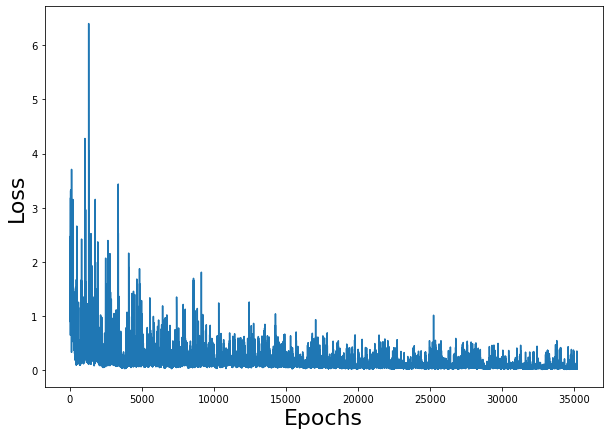

In [21]:
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Epochs",fontsize=22)
plt.ylabel("Loss",fontsize=22)

In [22]:
max_games = 1000
wins = 0
for i in range(max_games):
    win = test_model(model, mode='random', display=False)
    if win:
        wins += 1
win_perc = float(wins) / float(max_games)
print("Games played: {0}, # of wins: {1}".format(max_games,wins))
print("Win percentage: {}%".format(100.0*win_perc))

Games played: 1000, # of wins: 907
Win percentage: 90.7%


In [23]:
test_model(model, mode='random')

Initial State:
[[' ' ' ' 'P' ' ']
 [' ' ' ' 'W' ' ']
 [' ' ' ' ' ' ' ']
 ['+' ' ' '-' ' ']]
Move #: 0; Taking action: l
[[' ' 'P' ' ' ' ']
 [' ' ' ' 'W' ' ']
 [' ' ' ' ' ' ' ']
 ['+' ' ' '-' ' ']]
Move #: 1; Taking action: d
[[' ' ' ' ' ' ' ']
 [' ' 'P' 'W' ' ']
 [' ' ' ' ' ' ' ']
 ['+' ' ' '-' ' ']]
Move #: 2; Taking action: d
[[' ' ' ' ' ' ' ']
 [' ' ' ' 'W' ' ']
 [' ' 'P' ' ' ' ']
 ['+' ' ' '-' ' ']]
Move #: 3; Taking action: l
[[' ' ' ' ' ' ' ']
 [' ' ' ' 'W' ' ']
 ['P' ' ' ' ' ' ']
 ['+' ' ' '-' ' ']]
Move #: 4; Taking action: d
[[' ' ' ' ' ' ' ']
 [' ' ' ' 'W' ' ']
 [' ' ' ' ' ' ' ']
 ['+' ' ' '-' ' ']]
Game won! Reward: 10


True

###### Listing 3.7

In [24]:
import copy

l1 = 64
l2 = 150
l3 = 100
l4 = 4


model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.ReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.ReLU(),
    torch.nn.Linear(l3,l4)
)

model2 = copy.deepcopy(model) #A
model2.load_state_dict(model.state_dict()) #B

loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

gamma = 0.9
epsilon = 0.3

In [25]:
from collections import deque
epochs = 5000
losses = []
mem_size = 1000
batch_size = 200
replay = deque(maxlen=mem_size)
max_moves = 50
h = 0
sync_freq = 500 #A
j=0
for i in range(epochs):
    game = Gridworld(size=4, mode='random')
    state1_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
    state1 = torch.from_numpy(state1_).float()
    status = 1
    mov = 0
    while(status == 1): 
        j+=1
        mov += 1
        qval = model(state1)
        qval_ = qval.data.numpy()
        if (random.random() < epsilon):
            action_ = np.random.randint(0,4)
        else:
            action_ = np.argmax(qval_)
        
        action = action_set[action_]
        game.makeMove(action)
        state2_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
        state2 = torch.from_numpy(state2_).float()
        reward = game.reward()
        done = True if reward > 0 else False
        exp =  (state1, action_, reward, state2, done)
        replay.append(exp) #H
        state1 = state2
        
        if len(replay) > batch_size:
            minibatch = random.sample(replay, batch_size)
            state1_batch = torch.cat([s1 for (s1,a,r,s2,d) in minibatch])
            action_batch = torch.Tensor([a for (s1,a,r,s2,d) in minibatch])
            reward_batch = torch.Tensor([r for (s1,a,r,s2,d) in minibatch])
            state2_batch = torch.cat([s2 for (s1,a,r,s2,d) in minibatch])
            done_batch = torch.Tensor([d for (s1,a,r,s2,d) in minibatch])
            Q1 = model(state1_batch) 
            with torch.no_grad():
                Q2 = model2(state2_batch) #B
            
            Y = reward_batch + gamma * ((1-done_batch) * torch.max(Q2,dim=1)[0])
            X = Q1.gather(dim=1,index=action_batch.long().unsqueeze(dim=1)).squeeze()
            loss = loss_fn(X, Y.detach())
            print(i, loss.item())
            clear_output(wait=True)
            optimizer.zero_grad()
            loss.backward()
            losses.append(loss.item())
            optimizer.step()
            
            if j % sync_freq == 0: #C
                model2.load_state_dict(model.state_dict())
        if reward != -1 or mov > max_moves:
            status = 0
            mov = 0
        
losses = np.array(losses)

#A Set the update frequency for synchronizing the target model parameters to the main DQN
#B Use the target network to get the maiximum Q-value for the next state
#C Copy the main model parameters to the target network

4999 0.01339130848646164


Text(0, 0.5, 'Loss')

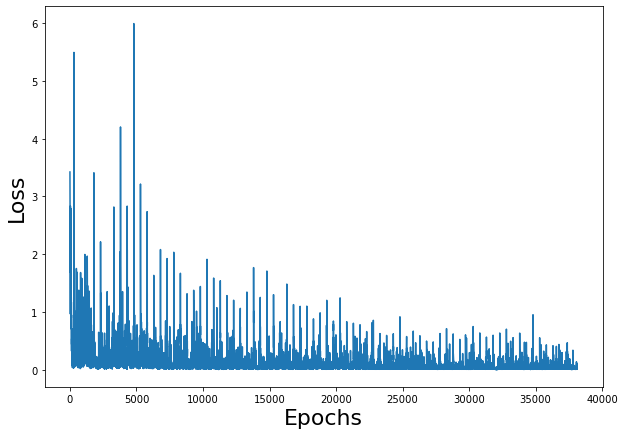

In [26]:
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Epochs",fontsize=22)
plt.ylabel("Loss",fontsize=22)

In [27]:
max_games = 1000
wins = 0
for i in range(max_games):
    win = test_model(model, mode='random', display=False)
    if win:
        wins += 1
win_perc = float(wins) / float(max_games)
print("Games played: {0}, # of wins: {1}".format(max_games,wins))
print("Win percentage: {}%".format(100.0*win_perc))

Games played: 1000, # of wins: 910
Win percentage: 91.0%
